# Investments Project (Spring 2024)

**Authors:**
- Marc-Antoine Allard
- Adam Zinebi
- Paul Teiletche
- ...

**DUE Date: June 21 at 23:59**

---
# Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from utils import annualized_metrics, plot_metrics, ew_strategy, rp_strategy, mv_strategy, scale_to_target_volatility

from functools import reduce

%load_ext autoreload 
%autoreload 2

In [3]:
DATA_PATH = "../data"

---
# 6 - Optimal Fund Portfolio Return (STRAT)

*We now assume that you are running a fund that invests its assets under management in 1-month TBills and adds an ‘overlay’ investment in the three strategies (BaB, IV, MoM) targeting an average annual volatility of 10%. Specifically, consider the return to the fund to be $R_{fund}=R_{T−Bill}+c * R_{STRAT}$,where $R_{STRAT}$ is the return to a strategy that combines BaB, IV, and MoM and where $c$ is a constant that you choose so that the average annual volatility $Vol(c * R_{STRAT})=10\%$.*

*Consider three different approaches to combine the three strategies, BaB, IV, MoM to generate $R_{STRAT}$* :
- *Equal weight the strategies.*
- *Risk-Parity based on the rolling window estimate of the strategy returns volatilities.*
- *Mean-variance optimal combination based on the rolling window mean and covariance matrix of the strategy returns.*

*For each of the three approaches to combining the strategies compute the overall mean, standard deviation, and Sharpe ratio of the resulting ‘optimal’ portfolio. Going forward pick the approach with the risk-parity.*

In [16]:
# Load returns
BaB_returns = pd.read_parquet(f'{DATA_PATH}/factors/bab_returns.parquet')
IV_returns = pd.read_parquet(f'{DATA_PATH}/factors/iv_returns.parquet')
MoM_returns = pd.read_parquet(f'{DATA_PATH}/factors/mom_returns.parquet')
T_bill_returns = pd.read_parquet(f'{DATA_PATH}/tbills.parquet')

returns_dfs = [BaB_returns, IV_returns, MoM_returns, T_bill_returns] # + BaB_returns, IV_returns
data = reduce(lambda l,r: pd.merge(l,r, on='date', sort=True), returns_dfs).groupby('date').mean().reset_index()

#data = data.iloc[-100:]

data.head()

,date,BAB,IV,MoM,rf
0,1969-02,-0.022723,-0.229660,-0.169273,0.004700
1,1969-03,-0.014554,0.039955,0.141174,0.004468
2,1969-04,-0.010209,0.056371,0.228163,0.005104
3,1969-05,0.017250,0.019172,0.149336,0.004871
4,1969-06,-0.022097,-0.219006,0.086337,0.005401


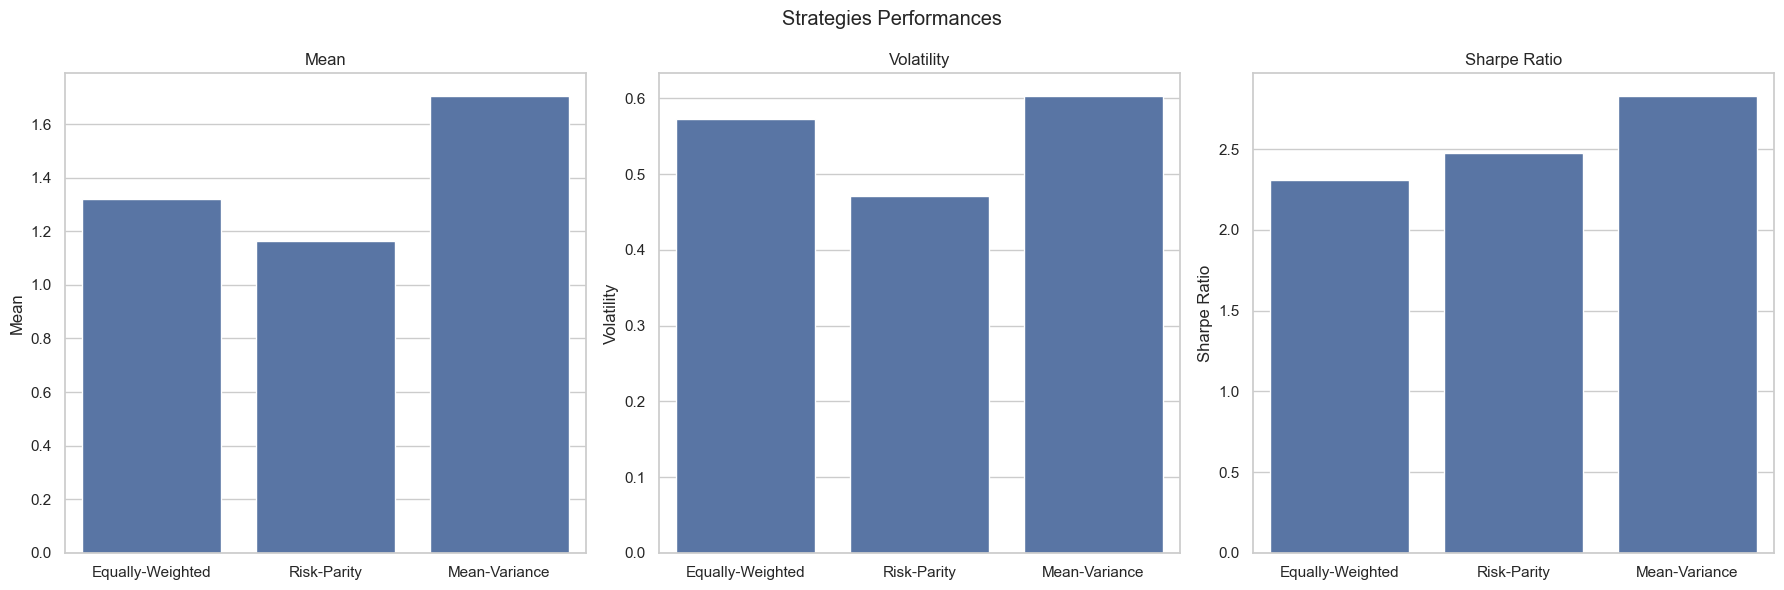

In [17]:
assets = ['rf']
factors_cols = ['IV', 'MoM']

# Calculate strategies
ew_returns = ew_strategy(data, factors_cols)
rp_returns = rp_strategy(data, factors_cols)
mv_returns = mv_strategy(data, factors_cols)

plot_metrics(pd.DataFrame({
            'Equally-Weighted': ew_returns,
            'Risk-Parity': rp_returns,
            'Mean-Variance': mv_returns
            }), 'Strategies Performances')

In [19]:
# Fund returns
def fund_return(strategy_returns, T_bill):
    return T_bill + scale_to_target_volatility(strategy_returns)

# Compute fund return
fund_ew = fund_return(ew_returns, data['rf'])
fund_rp = fund_return(rp_returns, data['rf'])
fund_mv = fund_return(mv_returns, data['rf'])

annualized_metrics(fund_ew, data['rf']), annualized_metrics(fund_rp, data['rf']), annualized_metrics(fund_mv, data['rf'])

((0.2305974574736383, 0.09980438208849514, 2.3104943154617277),
 (0.24771993926365546, 0.10007511137144715, 2.475340130716392),
 (0.2827437738393085, 0.10006852134387444, 2.825501666679881))